In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from scipy import constants

In [2]:

G = constants.G
c = constants.speed_of_light

kg=1.989*10**30 #kg
m = 1.989 * 10**30              # mass of the sun in kg
M = 10**6 * m                   # mass of BH
rho=1410 #density of the sun in kg/m^3 

r_star = 696340*10**3


In [3]:
"Initial conditions"

x0 =float(0)
y0 =float(8*10**9)     # close to the isco radius
v_x0 =  10**8
v_y0 =  0


In [4]:

def L(x,y, m):
    '''
    function that calculates the angular momentum for given x, y
    L is constant over time
    Since at point t = 0, we have only a velocity component in x-direction, so we calculate the L(0) = L(t) to be:
    '''
    print("x={},y={}".format(x,y))
    x = float(x)
    y = float(y)
    r = np.sqrt((x**2+y**2))
    return r*m*v_x0

L = L(x0, y0, m)
print("The angular momentum is",L)

A = G*M
B = L**2 / m**2             # 0.005
C = 3*G*M*L**2 / ((m**2)*c**2)   # 0.8

r_ss   = 2*A/c**2
r_isco = 3*r_ss
r_tidal = r_star * (M/m)**(1/3)

x=0.0,y=8000000000.0
The angular momentum is 1.5912e+48


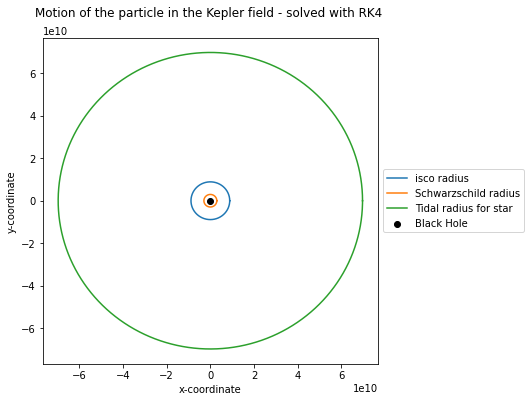

In [5]:
def cartesian(r):
    theta=np.linspace(0,2*np.pi,1000)
    x=r*(np.cos(theta))
    y=r*(np.sin(theta))
    return x,y

x_ss,y_ss=cartesian(r_ss)
x_isco,y_isco=cartesian(r_isco)
x_tidal,y_tidal=cartesian(r_tidal)

plt.figure(figsize=(6, 6))
plt.scatter(0,0, label= 'Black Hole', color = 'black')#, s = 300)
plt.plot(x_isco,y_isco, label = 'isco radius')
plt.plot(x_ss,y_ss, label = 'Schwarzschild radius')
plt.plot(x_tidal,y_tidal, label = 'Tidal radius for star')
plt.title('Motion of the particle in the Kepler field - solved with RK4 \n')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")


plt.show()

In [6]:
t = np.linspace(0,20000,25000)

t0 = t[0]

h = len(t)

#functions derived from the true black hole potential
def v_x_(t,x,y,v_x,v_y):
    r = np.sqrt((x**2+y**2))
    return -A*x / (r**3) + B*x / (r**4) - C*x / (r**5)

def v_y_(t,x,y,v_x,v_y):
    r = np.sqrt((x**2+y**2))
    return -A*y / r**3 + B*y / r**4 - C*y / r**5

def x_(t,x,y,v_x,v_y):
    return v_x

def y_(t,x,y,v_x,v_y):
    return v_y

In [7]:
#function that gives back an arrow of masses and radii from shells
def mnrn(n):
    masses_shells=[]
    masses_inner=[]
    radii=[]
    for i in range(n-1):
        r=r_star*(n-i)/n
        radii.append(r)
        mass_shell=m/n
        mass_inner=(n-i-1)*m/n
        masses_inner.append(mass_inner)
        masses_shells.append(mass_shell)
    return masses_shells,masses_inner,radii

In [8]:
#calculates the force from star onto the shells
def gravitation_star(n_shells):
    r_star = 696340*10**3
    grav_star=[]
    rad_star=[]
    for i in range(n_shells-1):
        r=r_star*(n_shells-i)/n_shells
        rad_star.append(r)
        mass_shell=m/n_shells
        #mass_inner=(n_shells-i-1)*m/n_shells
        F_star=(G*m*mass_shell)/(r**2) #in this function I changed mass_inner with m so the gravitational force is stronger
        grav_star.append(F_star)
    return grav_star,rad_star

#calculates the force from bh onto the shells
def force_bh(t,x,y,v_x,v_y,n_shells):
    A = G*M
    B = L**2 / (m/n_shells)**2            
    C = 3*G*M*L**2 / (((m/n_shells)**2)*c**2)  
    r=np.sqrt(x**2+y**2)
    ax=-A*x / (r**3) + B*x / (r**4) - C*x / (r**5)
    ay=-A*y / (r**3) + B*y / (r**4) - C*y / (r**5)
    a=np.sqrt(ax**2+ay**2)
    mass_shells,mass_inner,radii=mnrn(n_shells)
    F=[]
    for i in range(len(mass_shells)):
        F.append(mass_shells[i]*a)
    return F,radii

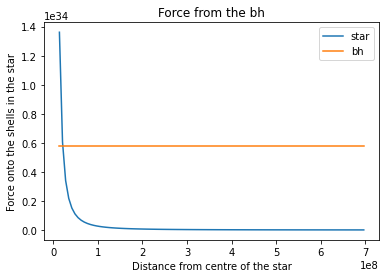

In [9]:
x0=4*r_tidal

gstar,rad_star=gravitation_star(100)
fbh,rad_star=force_bh(t,x0,y0,v_x0,v_y0,100)


plt.plot(rad_star,gstar,label="star")
plt.plot(rad_star,fbh,label="bh")

plt.xlabel("Distance from centre of the star")
plt.ylabel("Force onto the shells in the star")
plt.title("Force from the bh")
plt.legend()
plt.show()

The calculated tidal radius is  307910586902.8168
This is 4.421842589867261 times the true tidal radius
307910586902.8168


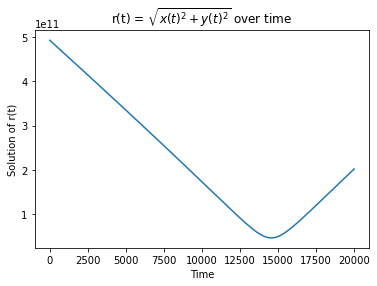

In [10]:
def my_rk4(x0,y0,v_x0,v_y0,h =0.4):
    '''
    This function solves the differential equations (the equation of motion)
    for the x- and y-component of a particle. At each step, we evaluate v[i] for x and y which corresponds to their derivatives 
    as well as the derivatives dot(v) for x and y which corresponds to their second order derivatives. 
    Since for the (i+1)-th step, we need the values of x, y, v_x and v_y for the i-th step, for each step we calculate these 4 values
    '''
    x = np.zeros(len(t))
    v_x = np.zeros(len(t))
    y = np.zeros(len(t))
    v_y = np.zeros(len(t))
    F_star,rad_star=gravitation_star(10)
    n=0
    x[0] = x0
    v_x[0] = v_x0
    y[0] = y0
    v_y[0] = v_y0
    r_calculated_tidal=False
    for i in range(0,len(t)-1):
        k1x =   (x_(    t[i], x[i], y[i], v_x[i], v_y[i]))
        k1v_x = (v_x_(  t[i], x[i], y[i], v_x[i], v_y[i]))
        k1y =   (y_(    t[i], x[i], y[i], v_x[i], v_y[i]))
        k1v_y = (v_y_(  t[i], x[i], y[i], v_x[i], v_y[i]))

        k2x =   (x_(    t[i]+ h/2, x[i]+ h*k1x/2, y[i]+ h*k1y/2, v_x[i]+ h*k1v_x/2, v_y[i]+ h*k1v_y/2))
        k2v_x = (v_x_(  t[i]+ h/2, x[i]+ h*k1x/2, y[i]+ h*k1y/2, v_x[i]+ h*k1v_x/2, v_y[i]+ h*k1v_y/2))
        k2y =   (y_(    t[i]+ h/2, x[i]+ h*k1x/2, y[i]+ h*k1y/2, v_x[i]+ h*k1v_x/2, v_y[i]+ h*k1v_y/2))
        k2v_y = (v_y_(  t[i]+ h/2, x[i]+ h*k1x/2, y[i]+ h*k1y/2, v_x[i]+ h*k1v_x/2, v_y[i]+ h*k1v_y/2))

        k3x =   (x_(    t[i]+ h/2, x[i]+ h*k2x/2, y[i]+ h*k2y/2, v_x[i]+ h*k2v_x/2, v_y[i]+ h*k2v_y/2))
        k3v_x = (v_x_(  t[i]+ h/2, x[i]+ h*k2x/2, y[i]+ h*k2y/2, v_x[i]+ h*k2v_x/2, v_y[i]+ h*k2v_y/2))
        k3y =   (y_(    t[i]+ h/2, x[i]+ h*k2x/2, y[i]+ h*k2y/2, v_x[i]+ h*k2v_x/2, v_y[i]+ h*k2v_y/2))
        k3v_y = (v_y_(  t[i]+ h/2, x[i]+ h*k2x/2, y[i]+ h*k2y/2, v_x[i]+ h*k2v_x/2, v_y[i]+ h*k2v_y/2))
        
        k4x =   (x_(    t[i]+ h, x[i]+ h*k3x/2, y[i]+ h*k3y/2, v_x[i]+ h*k3v_x/2, v_y[i]+ h*k3v_y/2))
        k4v_x = (v_x_(  t[i]+ h, x[i]+ h*k3x/2, y[i]+ h*k3y/2, v_x[i]+ h*k3v_x/2, v_y[i]+ h*k3v_y/2))
        k4y =   (y_(    t[i]+ h, x[i]+ h*k3x/2, y[i]+ h*k3y/2, v_x[i]+ h*k3v_x/2, v_y[i]+ h*k3v_y/2))
        k4v_y = (v_y_(  t[i]+ h, x[i]+ h*k3x/2, y[i]+ h*k3y/2, v_x[i]+ h*k3v_x/2, v_y[i]+ h*k3v_y/2))

        x[i+1]  = x[i] + (k1x+2*k2x+2*k3x+k4x)*h/6
        v_x[i+1]  = v_x[i] + (k1v_x+2*k2v_x+2*k3v_x+k4v_x)*h/6
        y[i+1]  = y[i] + (k1y+2*k2y+2*k3y+k4y)*h/6
        v_y[i+1]  = v_y[i] + (k1v_y+2*k2v_y+2*k3v_y+k4v_y)*h/6


        # define black hole radius to be one right now ---------> I put r_ss here, and not the radius of the bh, because no particle can escape after this point
        if np.sqrt(x[i]**2+y[i]**2) <= r_ss:    
            x[i] = 0
            y[i] = 0
            x = x[:i]
            y = y[:i]
            v_x = v_x[:i]
            v_y = v_y[:i]
            break
        F_bh,rad_star=force_bh(t[i],x[i],y[i],v_x[i],v_y[i],10)
        
        if F_bh[5]<F_star[5] and F_bh[4]>F_star[4] and n==0: #Looks where half of the shells should fly away
            r_calculated_tidal=np.sqrt(x[i]**2+y[i]**2)
            print("The calculated tidal radius is ",r_calculated_tidal)
            print("This is {} times the true tidal radius".format(r_calculated_tidal/r_tidal))
            n=1
    return x, y, v_x, v_y,r_calculated_tidal


x0=-7*r_tidal
y0=r_tidal     
v_x0 =10**7.8
v_y0 =  0
my_x, my_y, my_v_x, my_v_y,r_t = my_rk4(x0,y0,v_x0,v_y0)
print(r_t)
my_r = np.sqrt(my_x**2+ my_y**2)
my_v = np.sqrt(my_v_x**2+ my_v_y**2)
plt.figure()
plt.plot(t[:len(my_x)], my_r) 
plt.xlabel('Time')
plt.ylabel('Solution of r(t)')
plt.title('r(t) = $\sqrt{x(t)^2+y(t)^2}$ over time')
plt.show()



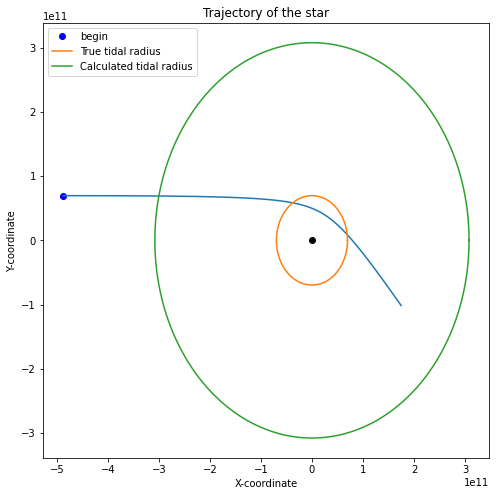

In [11]:
plt.figure(figsize=(8, 8))

plt.plot(my_x[0],my_y[0],"bo",label="begin")
plt.plot(my_x,my_y)
plt.plot(x_tidal,y_tidal, label = 'True tidal radius')
if r_t!=False:
    x_t,y_t=cartesian(r_t)
    plt.plot(x_t,y_t,label="Calculated tidal radius")


plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.plot(0,0,color="black",marker="o")
plt.title("Trajectory of the star")
plt.legend()
plt.show()